In [6]:
import numpy as np
import pandas as pd

In [7]:
def analytic_solution(a, b, vartheta, dt, t_max):
    x_analytic = []
    z_analytic = []
    p_x_analytic = []
    p_z_analytic = []
    time = []
    for time_step in range(int(t_max / dt) + 1):
        t = time_step * dt
        p_x = np.sin(vartheta) / a
        p_z = p_x * np.sinh(np.arctanh(np.cos(vartheta)) - b * t)
        x = (a / (b * np.sin(vartheta))) * (np.tanh(b * t - np.arctanh(np.cos(vartheta))) + np.cos(vartheta))
        z = (a / b) * (1 / (np.sin(vartheta) * np.cosh(np.arctanh(np.cos(vartheta)) - b * t)) - 1)

        time.append(t)
        x_analytic.append(x)
        z_analytic.append(z)
        p_x_analytic.append(p_x)
        p_z_analytic.append(p_z)

    data_df = pd.DataFrame({
        'x': x_analytic,
        'z': z_analytic,
        'p_x': p_x_analytic,
        'p_z': p_z_analytic,
        't': time
    })

    return data_df


In [8]:
def generate_training_time(t_max, dt):
    training_time = []
    for i in range(int(t_max/dt + 1)):
        training_time.append(i*dt)
    return training_time

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

torch.manual_seed(0)

# model
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.linear_5 = nn.Linear(hidden_size, hidden_size)
        self.linear_6 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, 4)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))
        x = torch.tanh(self.linear_4(x))
        x = torch.tanh(self.linear_5(x))
        x = torch.tanh(self.linear_6(x))
        x = self.linear_output(x)
        return x

hidden_size= 48
num_epochs = 30000
lr=0.001

a = 2
b = 1
t_max = 5
dt = 0.01
vartheta = np.pi/12

In [10]:
# Define the model, loss function, optimizer and scheduler
model = Net(hidden_size=hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

training_time = generate_training_time(t_max, dt)
training_time_tensor = torch.tensor(training_time)

initial_time = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
final_time = torch.tensor([t_max], dtype=torch.float32).requires_grad_(True)

batch_size = len(training_time_tensor)
dataset = TensorDataset(training_time_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_total = []
losses_physics = []
losses_IC = []
losses_energy = []

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    for batch in data_loader:
        batch_time = torch.tensor(batch[0])
        batch_time = batch_time.requires_grad_(True).view(-1, 1)

        ##################################################################################
        # Calculate the physics loss

        output = model(batch_time)
        output_x = output[:, 0].view(-1, 1)
        output_z = output[:, 1].view(-1, 1)
        output_p_x = output[:, 2].view(-1, 1)
        output_p_z = output[:, 3].view(-1, 1)

        v = a + b * output_z

        ##################################################################################
        # Calculate the derivatives

        xdot = torch.autograd.grad(output_x, batch_time, torch.ones_like(output_x), create_graph=True)[0]
        zdot = torch.autograd.grad(output_z, batch_time, torch.ones_like(output_z), create_graph=True)[0]
        p_x_dot = torch.autograd.grad(output_p_x, batch_time, torch.ones_like(output_p_x), create_graph=True)[0]
        p_z_dot = torch.autograd.grad(output_p_z, batch_time, torch.ones_like(output_p_z), create_graph=True)[0]

        ##################################################################################
        # Write down the Hamiltonian and calculate the energy loss

        h = (1/2) * (a + b * output_z)**2 * (output_p_x**2 + output_p_z**2) - 1/2
        energy_loss = torch.mean(h**2)

        ##################################################################################
        # Calculate the physics loss

        h_x = (xdot - (a + b * output_z)**2 * output_p_x)
        h_z = (zdot - (a + b * output_z)**2 * output_p_z)
        h_p_x = (p_x_dot)
        h_p_z = (p_z_dot + b * (a + b * output_z) * (output_p_x**2 + output_p_z**2))

        physics_x_loss = torch.mean(h_x**2)
        physics_z_loss = torch.mean(h_z**2)
        physics_p_x_loss = torch.mean(h_p_x**2)
        physics_p_z_loss = torch.mean(h_p_z**2)


        ##################################################################################
        # Calculate the initial position and momentum loss

        x_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
        z_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)

        initial_outputs = model(initial_time)

        initial_position_loss_x = (initial_outputs[0] - x_0_tensor)**2
        initial_position_loss_z = (initial_outputs[1] - z_0_tensor)**2

        v_0 = a + b * z_0_tensor
        initial_momentum_loss_x = (initial_outputs[2] - np.sin(vartheta)/(v_0)) ** 2
        initial_momentum_loss_z = (initial_outputs[3] - np.cos(vartheta)/(v_0)) ** 2

        ##################################################################################
        # Calculate the total loss
        physics_loss = physics_x_loss * 1e2 +  physics_z_loss * 1e2 + physics_p_x_loss * 1e4 + physics_p_z_loss * 1e4
        IC_loss = initial_position_loss_x * 1e2 + initial_position_loss_z * 1e2 + initial_momentum_loss_x * 1e4 + initial_momentum_loss_z * 1e4

        total_loss =  physics_x_loss * 1e2 +  physics_z_loss * 1e2 + physics_p_x_loss * 1e4 + physics_p_z_loss * 1e4 + initial_position_loss_x * 1e2 + initial_position_loss_z * 1e2 + initial_momentum_loss_x * 1e4 + initial_momentum_loss_z * 1e4 + energy_loss * 1e2

        ##################################################################################

        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        ##################################################################################

        # Save the losses

        losses_physics.append(physics_loss.item())
        losses_IC.append(IC_loss.item())
        losses_energy.append(energy_loss.item())
        losses_total.append(total_loss.item())


    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss.item():.2e}, "
              f"Total Physics Loss: {physics_loss.item():.2e}, "
              f"Initial Position Loss x: {initial_position_loss_x.item():.2e}, "
              f"Initial Position Loss z: {initial_position_loss_z.item():.2e}, "
              f"Initial Momentum Loss x: {initial_momentum_loss_x.item():.2e}, "
              f"Initial Momentum Loss z: {initial_momentum_loss_z.item():.2e}, "
              f"Energy Loss: {energy_loss.item():.2e}, "
              f"LR: {optimizer.param_groups[0]['lr']}")

    ##############################################################################

    # if the learning rate is too low, do not decrease the learning rate
    if optimizer.param_groups[0]['lr'] > 1e-6:
        scheduler.step()  # Update the learning rate

  0%|          | 0/30000 [00:00<?, ?it/s]<ipython-input-10-279cb5560879>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_time = torch.tensor(batch[0])
  3%|▎         | 1005/30000 [00:23<10:44, 45.01it/s]

Epoch 1000/30000, Total Loss: 3.58e+01, Total Physics Loss: 1.78e+01, Initial Position Loss x: 8.96e-07, Initial Position Loss z: 3.07e-02, Initial Momentum Loss x: 5.32e-06, Initial Momentum Loss z: 1.97e-05, Energy Loss: 1.46e-01, LR: 0.001


  7%|▋         | 2008/30000 [00:47<13:06, 35.60it/s]

Epoch 2000/30000, Total Loss: 1.09e+01, Total Physics Loss: 4.59e+00, Initial Position Loss x: 2.36e-05, Initial Position Loss z: 4.04e-03, Initial Momentum Loss x: 6.74e-07, Initial Momentum Loss z: 3.56e-06, Energy Loss: 5.90e-02, LR: 0.0009000000000000001


 10%|█         | 3002/30000 [01:09<14:30, 31.03it/s]

Epoch 3000/30000, Total Loss: 8.00e+00, Total Physics Loss: 3.49e+00, Initial Position Loss x: 6.11e-03, Initial Position Loss z: 2.74e-04, Initial Momentum Loss x: 8.64e-07, Initial Momentum Loss z: 3.64e-07, Energy Loss: 3.85e-02, LR: 0.0008100000000000001


 13%|█▎        | 4006/30000 [01:32<09:05, 47.66it/s]

Epoch 4000/30000, Total Loss: 7.03e+00, Total Physics Loss: 3.72e+00, Initial Position Loss x: 1.84e-04, Initial Position Loss z: 4.01e-03, Initial Momentum Loss x: 2.19e-06, Initial Momentum Loss z: 1.54e-06, Energy Loss: 2.85e-02, LR: 0.000729


 17%|█▋        | 5006/30000 [01:56<08:39, 48.07it/s]

Epoch 5000/30000, Total Loss: 4.04e+00, Total Physics Loss: 1.61e+00, Initial Position Loss x: 4.02e-05, Initial Position Loss z: 1.06e-03, Initial Momentum Loss x: 1.66e-06, Initial Momentum Loss z: 4.28e-07, Energy Loss: 2.29e-02, LR: 0.0006561000000000001


 20%|██        | 6007/30000 [02:23<09:07, 43.86it/s]

Epoch 6000/30000, Total Loss: 3.26e+00, Total Physics Loss: 1.34e+00, Initial Position Loss x: 1.77e-04, Initial Position Loss z: 9.44e-04, Initial Momentum Loss x: 1.33e-06, Initial Momentum Loss z: 5.11e-07, Energy Loss: 1.79e-02, LR: 0.00059049


 23%|██▎       | 7009/30000 [02:46<07:55, 48.35it/s]

Epoch 7000/30000, Total Loss: 2.57e+00, Total Physics Loss: 1.12e+00, Initial Position Loss x: 9.00e-06, Initial Position Loss z: 5.22e-04, Initial Momentum Loss x: 1.60e-06, Initial Momentum Loss z: 2.75e-07, Energy Loss: 1.38e-02, LR: 0.000531441


 27%|██▋       | 8005/30000 [03:09<07:50, 46.73it/s]

Epoch 8000/30000, Total Loss: 2.06e+00, Total Physics Loss: 9.34e-01, Initial Position Loss x: 1.44e-06, Initial Position Loss z: 3.64e-04, Initial Momentum Loss x: 1.60e-06, Initial Momentum Loss z: 1.90e-07, Energy Loss: 1.07e-02, LR: 0.0004782969


 30%|███       | 9005/30000 [03:32<07:23, 47.39it/s]

Epoch 9000/30000, Total Loss: 1.64e+00, Total Physics Loss: 7.64e-01, Initial Position Loss x: 2.27e-06, Initial Position Loss z: 2.24e-04, Initial Momentum Loss x: 1.49e-06, Initial Momentum Loss z: 9.70e-08, Energy Loss: 8.34e-03, LR: 0.00043046721


 33%|███▎      | 10008/30000 [03:57<08:05, 41.21it/s]

Epoch 10000/30000, Total Loss: 2.79e+00, Total Physics Loss: 1.94e+00, Initial Position Loss x: 1.24e-03, Initial Position Loss z: 1.92e-04, Initial Momentum Loss x: 2.04e-06, Initial Momentum Loss z: 4.22e-07, Energy Loss: 6.88e-03, LR: 0.000387420489


 37%|███▋      | 11005/30000 [04:20<09:40, 32.74it/s]

Epoch 11000/30000, Total Loss: 9.97e-01, Total Physics Loss: 4.81e-01, Initial Position Loss x: 5.72e-07, Initial Position Loss z: 1.36e-04, Initial Momentum Loss x: 1.00e-06, Initial Momentum Loss z: 5.60e-08, Energy Loss: 4.92e-03, LR: 0.0003486784401


 40%|████      | 12009/30000 [04:42<06:22, 47.05it/s]

Epoch 12000/30000, Total Loss: 1.31e+00, Total Physics Loss: 6.60e-01, Initial Position Loss x: 2.31e-03, Initial Position Loss z: 3.67e-06, Initial Momentum Loss x: 2.27e-06, Initial Momentum Loss z: 7.08e-07, Energy Loss: 3.87e-03, LR: 0.00031381059609000004


 43%|████▎     | 13007/30000 [05:06<05:57, 47.58it/s]

Epoch 13000/30000, Total Loss: 1.35e+00, Total Physics Loss: 8.56e-01, Initial Position Loss x: 1.35e-03, Initial Position Loss z: 1.26e-04, Initial Momentum Loss x: 1.83e-06, Initial Momentum Loss z: 4.21e-07, Energy Loss: 3.27e-03, LR: 0.00028242953648100003


 47%|████▋     | 14006/30000 [05:29<05:25, 49.09it/s]

Epoch 14000/30000, Total Loss: 5.08e-01, Total Physics Loss: 2.54e-01, Initial Position Loss x: 2.04e-09, Initial Position Loss z: 7.44e-05, Initial Momentum Loss x: 4.56e-07, Initial Momentum Loss z: 3.58e-08, Energy Loss: 2.41e-03, LR: 0.00025418658283290005


 50%|█████     | 15009/30000 [05:52<05:19, 46.89it/s]

Epoch 15000/30000, Total Loss: 8.19e-01, Total Physics Loss: 4.33e-01, Initial Position Loss x: 1.63e-03, Initial Position Loss z: 7.58e-10, Initial Momentum Loss x: 1.40e-06, Initial Momentum Loss z: 5.93e-07, Energy Loss: 2.04e-03, LR: 0.00022876792454961005


 53%|█████▎    | 16007/30000 [06:15<06:52, 33.93it/s]

Epoch 16000/30000, Total Loss: 3.71e-01, Total Physics Loss: 1.91e-01, Initial Position Loss x: 1.79e-07, Initial Position Loss z: 5.38e-05, Initial Momentum Loss x: 2.92e-07, Initial Momentum Loss z: 2.46e-08, Energy Loss: 1.70e-03, LR: 0.00020589113209464906


 57%|█████▋    | 17010/30000 [06:37<04:24, 49.13it/s]

Epoch 17000/30000, Total Loss: 1.07e+00, Total Physics Loss: 7.07e-01, Initial Position Loss x: 1.05e-03, Initial Position Loss z: 8.46e-04, Initial Momentum Loss x: 8.53e-09, Initial Momentum Loss z: 3.48e-06, Energy Loss: 1.43e-03, LR: 0.00018530201888518417


 60%|██████    | 18007/30000 [07:02<04:07, 48.41it/s]

Epoch 18000/30000, Total Loss: 3.10e-01, Total Physics Loss: 1.64e-01, Initial Position Loss x: 1.37e-05, Initial Position Loss z: 9.92e-05, Initial Momentum Loss x: 1.27e-07, Initial Momentum Loss z: 1.09e-07, Energy Loss: 1.33e-03, LR: 0.00016677181699666576


 63%|██████▎   | 19009/30000 [07:26<03:46, 48.58it/s]

Epoch 19000/30000, Total Loss: 1.05e+00, Total Physics Loss: 7.55e-01, Initial Position Loss x: 1.14e-03, Initial Position Loss z: 1.77e-04, Initial Momentum Loss x: 1.02e-06, Initial Momentum Loss z: 1.84e-06, Energy Loss: 1.36e-03, LR: 0.0001500946352969992


 67%|██████▋   | 20010/30000 [07:49<03:21, 49.62it/s]

Epoch 20000/30000, Total Loss: 2.45e-01, Total Physics Loss: 1.32e-01, Initial Position Loss x: 5.67e-08, Initial Position Loss z: 4.17e-05, Initial Momentum Loss x: 1.27e-07, Initial Momentum Loss z: 2.37e-08, Energy Loss: 1.07e-03, LR: 0.0001350851717672993


 70%|███████   | 21004/30000 [08:12<03:27, 43.41it/s]

Epoch 21000/30000, Total Loss: 2.28e-01, Total Physics Loss: 1.24e-01, Initial Position Loss x: 1.41e-07, Initial Position Loss z: 3.81e-05, Initial Momentum Loss x: 1.02e-07, Initial Momentum Loss z: 2.05e-08, Energy Loss: 9.88e-04, LR: 0.00012157665459056936


 73%|███████▎  | 22006/30000 [08:36<02:47, 47.72it/s]

Epoch 22000/30000, Total Loss: 2.11e-01, Total Physics Loss: 1.16e-01, Initial Position Loss x: 1.37e-07, Initial Position Loss z: 3.61e-05, Initial Momentum Loss x: 8.35e-08, Initial Momentum Loss z: 1.98e-08, Energy Loss: 9.07e-04, LR: 0.00010941898913151243


 77%|███████▋  | 23005/30000 [08:59<03:43, 31.35it/s]

Epoch 23000/30000, Total Loss: 2.08e-01, Total Physics Loss: 1.16e-01, Initial Position Loss x: 4.27e-05, Initial Position Loss z: 1.57e-05, Initial Momentum Loss x: 1.42e-07, Initial Momentum Loss z: 7.06e-09, Energy Loss: 8.46e-04, LR: 9.847709021836118e-05


 80%|████████  | 24006/30000 [09:22<02:07, 47.05it/s]

Epoch 24000/30000, Total Loss: 1.87e-01, Total Physics Loss: 1.05e-01, Initial Position Loss x: 7.72e-07, Initial Position Loss z: 3.01e-05, Initial Momentum Loss x: 5.92e-08, Initial Momentum Loss z: 1.20e-08, Energy Loss: 7.88e-04, LR: 8.862938119652506e-05


 83%|████████▎ | 25006/30000 [09:45<01:45, 47.20it/s]

Epoch 25000/30000, Total Loss: 1.79e-01, Total Physics Loss: 9.97e-02, Initial Position Loss x: 1.10e-06, Initial Position Loss z: 4.49e-05, Initial Momentum Loss x: 3.38e-08, Initial Momentum Loss z: 5.47e-08, Energy Loss: 7.40e-04, LR: 7.976644307687256e-05


 87%|████████▋ | 26010/30000 [10:08<01:20, 49.67it/s]

Epoch 26000/30000, Total Loss: 1.70e-01, Total Physics Loss: 9.57e-02, Initial Position Loss x: 6.29e-07, Initial Position Loss z: 4.26e-05, Initial Momentum Loss x: 2.95e-08, Initial Momentum Loss z: 4.62e-08, Energy Loss: 6.91e-04, LR: 7.17897987691853e-05


 90%|█████████ | 27007/30000 [10:31<01:06, 45.26it/s]

Epoch 27000/30000, Total Loss: 1.61e-01, Total Physics Loss: 9.19e-02, Initial Position Loss x: 8.36e-07, Initial Position Loss z: 2.70e-05, Initial Momentum Loss x: 3.10e-08, Initial Momentum Loss z: 1.08e-08, Energy Loss: 6.59e-04, LR: 6.461081889226677e-05


 93%|█████████▎| 28007/30000 [10:55<00:44, 45.28it/s]

Epoch 28000/30000, Total Loss: 1.54e-01, Total Physics Loss: 8.79e-02, Initial Position Loss x: 1.33e-07, Initial Position Loss z: 2.97e-05, Initial Momentum Loss x: 2.20e-08, Initial Momentum Loss z: 1.87e-08, Energy Loss: 6.22e-04, LR: 5.81497370030401e-05


 97%|█████████▋| 29005/30000 [11:18<00:33, 29.91it/s]

Epoch 29000/30000, Total Loss: 1.58e-01, Total Physics Loss: 9.10e-02, Initial Position Loss x: 9.39e-06, Initial Position Loss z: 5.92e-05, Initial Momentum Loss x: 5.43e-09, Initial Momentum Loss z: 1.34e-07, Energy Loss: 5.91e-04, LR: 5.233476330273609e-05


100%|██████████| 30000/30000 [11:41<00:00, 42.76it/s]

Epoch 30000/30000, Total Loss: 1.44e-01, Total Physics Loss: 8.25e-02, Initial Position Loss x: 1.34e-06, Initial Position Loss z: 3.89e-05, Initial Momentum Loss x: 7.53e-09, Initial Momentum Loss z: 5.33e-08, Energy Loss: 5.65e-04, LR: 4.7101286972462485e-05


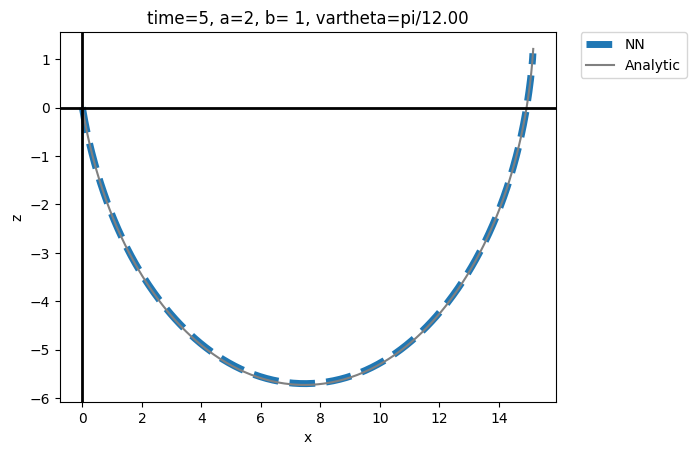

In [11]:
result_outputs = model(training_time_tensor.view(-1, 1))

result_outputs_df = pd.DataFrame(result_outputs.detach().numpy())
result_outputs_df.columns = ['x', 'z', 'p_x', 'p_z']
result_outputs_df["t"] = training_time


result_outputs_df["z"] = result_outputs_df["z"] * -1
result_outputs_df["slope"] = result_outputs_df["x"] / result_outputs_df["z"]


result_outputs_df.to_excel("result_outputs_df.xlsx")

true_solution_df = analytic_solution(a, b, vartheta, dt, t_max)


plt.plot(result_outputs_df["x"],  result_outputs_df["z"], label = "NN",  linewidth=5, c = "tab:blue", linestyle='dashed')
plt.plot(true_solution_df["x"], true_solution_df["z"] * - 1, label = "Analytic", c = "grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(f"time={t_max}, a={a}, b= {b}, vartheta=pi/{np.pi/vartheta:.2f}")
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.xlabel("x")
plt.ylabel("z")
#plt.xlim(-0.1, 2.8)
#plt.ylim(-2.25, 0.2)
plt.show()

Final loss: 0.14358314871788025


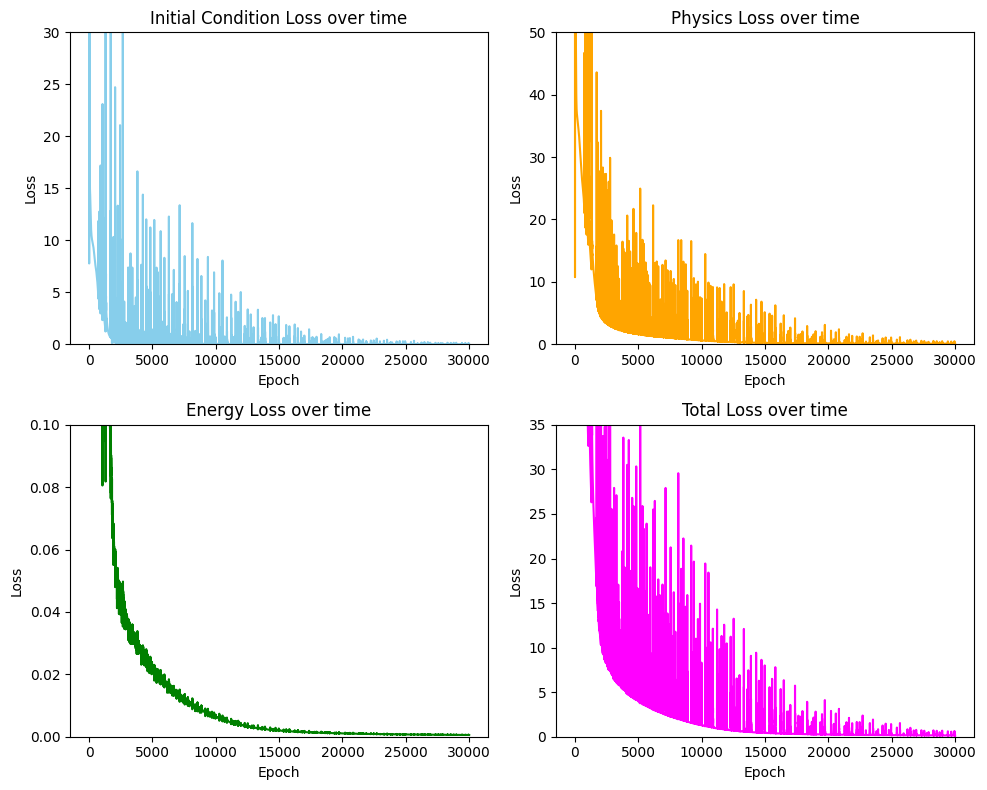

In [12]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(losses_IC, label='Initial Condition Loss ', color='skyblue')
axs[0, 0].set_title('Initial Condition Loss over time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 30)

axs[0, 1].plot(losses_physics, label='Hamiltonian Loss', color='orange')
axs[0, 1].set_title('Physics Loss over time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, 50)

axs[1, 0].plot(losses_energy, label='Energy Loss', color='green')
axs[1, 0].set_title('Energy Loss over time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_ylim(0, 1e-1)

axs[1, 1].plot(losses_total, label='Total Loss', color='magenta')
axs[1, 1].set_title('Total Loss over time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_ylim(0, 35)

plt.tight_layout()
plt.show()
